# **PGP AI and ML**

# **Name: Satyam Singh**

# **Topic: Industry Capstone Project (Action Recognition)**



### ***IMPORTANT LIBRARIES***

---



In [0]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()                                                                       
%matplotlib inline                                                              

import cv2 
from google.colab.patches import cv2_imshow        

import keras
import tensorflow 
from keras.applications.vgg16 import VGG16
from keras.engine.sequential import Sequential    
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, InputLayer, Conv2D, MaxPool2D, Activation, Concatenate,add

from keras.models import Model, load_model, model_from_json
from keras.preprocessing.image import load_img, img_to_array

from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping 

import warnings
warnings.filterwarnings('ignore') 

from sklearn.model_selection import train_test_split 

### ***Setting Up File Directory***


In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/Project/ActionRecognition')  
os.listdir()[:3] 

['Pose_Dataset', 'Pose_model', 'Action_Dataset']

In [0]:
cwd= os.getcwd() 

### ***Directory Containing Images***

In [0]:
#Training Images
train_imgs = ('/').join([cwd,'Pose_Dataset/train/images'])  
test_imgs = ('/').join([cwd,'Pose_Dataset/test/images'])      

### ***Loading DataFrame Containing Image Names with it Respective Joints Co-ordinates***

In [0]:
#Training DataFrame
path= ('/').join([cwd, 'Pose_Dataset/train_joints_coords.csv'])  
train_df=pd.read_csv(path, header=None)

#Testing DataFrame
path= ('/').join([cwd, 'Pose_Dataset/test_joints_coords.csv'])
test_df=pd.read_csv(path, header=None)     

In [8]:
print('Shape: ', train_df.shape)
train_df.head()  

Shape:  (4429, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,train0.jpg,190,160,149,137,151,84,122,34,47,77,31,141,31,190
1,train1.jpg,192,137,148,122,138,77,109,40,47,79,36,140,34,184
2,train2.jpg,190,139,147,116,139,72,103,33,37,82,33,148,47,188
3,train3.jpg,185,157,145,134,141,82,114,41,38,85,32,149,76,184
4,train4.jpg,44,182,38,139,53,83,119,38,155,91,172,139,195,177


***From DataFrame we can See that Column 0 contains Name of Images and Column 1 to 14 contain Joint Co-ordinates***

### ***Let's have a clear Look at Data(Images) and Target(Joints)***

(-0.5, 223.5, 223.5, -0.5)

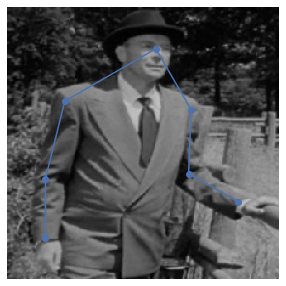

In [0]:
#Loading an Image
img = cv2.imread(train_imgs + '/train0.jpg')

#Storing Respective Coordinates of img
cord=train_df.iloc[0,1:].values 

# Seperating 'x' and 'y' points in list named x,y respectively. 
x=[];y=[] 
for i in range(0, len(cord), 2): 
  x.append(cord[i]) ;y.append(cord[i+1])  

#Plotting using Matplotlib
plt.figure(figsize= (5,5)) 
plt.imshow(img);plt.plot(x,y, 'bo-');plt.grid(False);plt.axis(False)   

***Clearly it can be seen that Given an Image we need to predict 7 joints Coordinates for Pose Estimation***

### **Reading CSV File** which is a supervised data for predicting Action Hello/Namaste 

In [9]:
path= cwd + '/Action_Dataset'
df = pd.read_csv(path+'/action_joints.csv')
df.columns= list(range(df.shape[1]))
df.head()  

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,hello1.jpg,152,205,165,152,157,96,123,64,106,90,81,74,48,28,Hello
1,hello2.jpg,142,184,144,133,134,93,105,56,86,84,60,65,45,19,Hello
2,hello3.jpg,155,202,151,149,141,109,101,71,60,105,47,73,53,40,Hello
3,hello4.jpg,167,216,159,161,165,111,147,66,87,88,41,102,65,49,Hello
4,hello5.jpg,140,194,137,144,131,100,105,70,77,92,60,75,60,37,Hello


Text(0.5, 1.0, 'Hello')

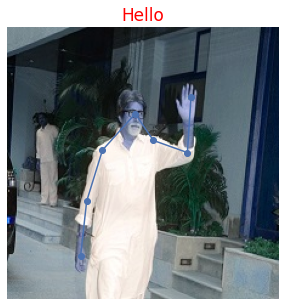

In [0]:
#Loading Images
img = cv2.imread(cwd + '/Action_Dataset/hello_test.jpg')

#Storing Respective Coordinates
cord=df.iloc[20,1:-1].values 

#x and y points in list named x,y respectively 
x=[];y=[] 
for i in range(0,len(cord), 2): 
  x.append(cord[i]) ;y.append(cord[i+1])  

plt.figure(figsize= (5,5)) 
plt.imshow(img);plt.plot(x,y, 'bo-');plt.grid(False);plt.axis(False)
plt.title(df.iloc[0,-1], color= 'red', size=17) 

### ***CREATING IMAGEGENERATOR TO LOAD IMAGES For Training Pose Estimation Model USING IMAGE-GENERATOR METHOD***

In [10]:
#Setting up Batch Size and Target Size for loading images
batch_size=40
target_size=(224,224) #I have set this because I am goint to Use VGG16 ConvNet model which has this as input_shape

#training generator
generator=ImageDataGenerator(validation_split=0.10) #Making 10% of Training Data as Validation Data for improving Model Learning
train_generator = generator.flow_from_dataframe(train_df, directory = train_imgs,
                                                x_col=0 ,y_col=list(np.arange(1,15,1)), 
                                                class_mode= 'raw', target_size= (224,224), 
                                                subset='training',batch_size=batch_size)
val_generator = generator.flow_from_dataframe(train_df, directory = train_imgs,
                                              x_col=0 ,y_col=list(np.arange(1,15,1)), 
                                              class_mode= 'raw', target_size= (224,224), 
                                              subset='validation',batch_size=batch_size) 
#test generator 
generator=ImageDataGenerator()
test_generator = generator.flow_from_dataframe(test_df, directory = test_imgs,x_col=0 ,y_col=list(np.arange(1,15,1)), class_mode= 'raw', target_size= (224,224),batch_size=batch_size)

Found 3987 validated image filenames.
Found 442 validated image filenames.
Found 574 validated image filenames.


# **Model Creation**

**Loading Base Model VGG16**

---


### ![alt text](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png) 

In [11]:
# LOAD BASE MODEL VGG16
    conv_base = VGG16(weights= 'imagenet', include_top= False, input_shape= (224,224,3))

#Setting Trainable parameters of our Base Model as Non-Trainable
    for layer in conv_base.layers:
        layer.trainable= False              

58892288/58889256 [==============================] - 2s 0us/step


### ***Building Model on Top of Our VGG16(Base Model)***

In [0]:
def top_model():

    top_model = Sequential()  
    top_model.add(Conv2D(64,(3,3), activation='relu', padding = 'same', input_shape=conv_base.output_shape[1:])) 
    top_model.add(BatchNormalization())
    top_model.add(MaxPool2D(pool_size=(2,2), strides=(1,1))) 

    top_model.add(Flatten()) 
     
    top_model.add(Dense(4096, activation='relu')) 
    top_model.add(BatchNormalization()) 
    top_model.add(Dropout(0.5))
    top_model.add(Dense(14//ns, activation='relu'))  #for ns =2 it will be 14//2 == 7

    # CREATE AN "REAL" MODEL NAMED "pose_model" FROM VGG16 BY COPYING ALL THE LAYERS OF VGG16
    model = Sequential() 
    for layer in conv_base.layers:
        model.add(layer)     

    # CONCATENATE THE TWO MODELS
    model.add(top_model) 

    return model

def create_model(n):
    outputs=[]
    for i in range(1,n+1):
        globals()[f'model_{i}'] = top_model()
        
        outputs.append(globals()[f'model_{i}'].output)
    
    merged= add(outputs)                              
    output= Dense(14, activation='relu', kernel_initializer= 'Ones')(merged) 

    final_model = Model(inputs= conv_base.input, output= output)
    
    return final_model         

In [61]:
ns=2 #Number of Groups in Which The Model need To be Build 
pose_model = create_model(ns)   # ns: as Number of Stages  for training.
pose_model.summary()  

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[17][0]              
                                                                 block1_conv1[18][0]              
____________________________________________________________________________________________

### **Compiling our Pose_Model**

In [0]:
from keras import backend as K

#Custom Metrics R2_Score
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

optimizer= Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)    
loss='mean_squared_error'                                                                                                       
metrics=[coeff_determination]                                               
pose_model.compile(optimizer= optimizer, loss=loss,  metrics=metrics)                          

**For Monitoring Val_loss Which is Our Validation Loss**

In [0]:
early_stopping_monitor= EarlyStopping(monitor='val_coeff_determination', min_delta=0, patience=10, 
                                      verbose=0, mode= 'max', baseline=None, restore_best_weights=True)       

### **Training Pose Estimation Model**

In [102]:
pose_model.fit_generator(train_generator, validation_data=val_generator, epochs=50,  
                         callbacks=[early_stopping_monitor],                        
                         steps_per_epoch= train_generator.samples//batch_size,    
                         validation_steps= val_generator.samples//df.shape[0])                    

Epoch 1/50
99/99 [==============================] - 53s 539ms/step - loss: 96.3974 - coeff_determination: 0.9677 - val_loss: 333.7280 - val_coeff_determination: 0.8725
Epoch 2/50
99/99 [==============================] - 51s 519ms/step - loss: 94.5421 - coeff_determination: 0.9683 - val_loss: 297.1754 - val_coeff_determination: 0.9229
Epoch 3/50
99/99 [==============================] - 52s 525ms/step - loss: 94.6447 - coeff_determination: 0.9682 - val_loss: 175.1101 - val_coeff_determination: 0.9164
Epoch 4/50
99/99 [==============================] - 52s 527ms/step - loss: 91.5620 - coeff_determination: 0.9693 - val_loss: 498.3387 - val_coeff_determination: 0.9149
Epoch 5/50
99/99 [==============================] - 52s 525ms/step - loss: 92.9150 - coeff_determination: 0.9688 - val_loss: 171.0086 - val_coeff_determination: 0.9278
Epoch 6/50
99/99 [==============================] - 52s 523ms/step - loss: 93.8786 - coeff_determination: 0.9685 - val_loss: 332.9764 - val_coeff_determination:

### **Evaluating on Test Data**

In [96]:
#Using Evaluate generator                                                              
pose_model.evaluate_generator(test_generator, steps= test_generator.samples//batch_size)     

[166.92776489257812, 0.9314650297164917]

##**Our Model for Pose Estimation gave 0.93 as it's Best R2_Score Value**

### **Visualizing Result on Picking the 5 Random Test Images**

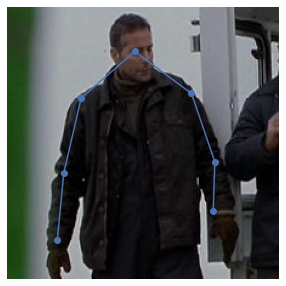

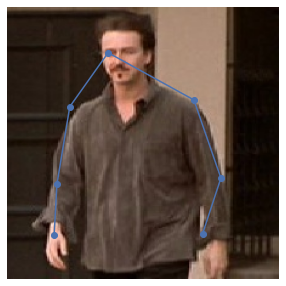

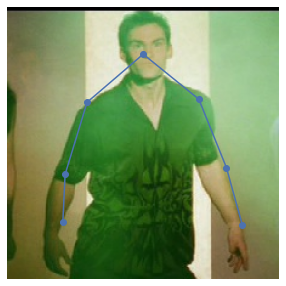

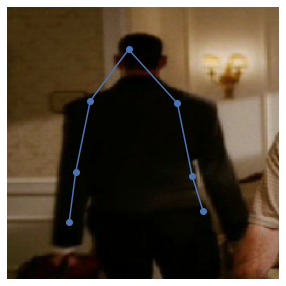

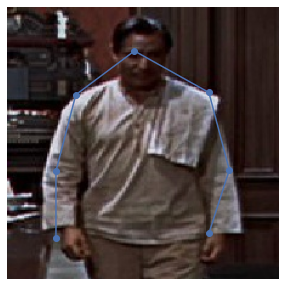

In [206]:

for i in range(5):

    random_n = np.random.randint(low=1, high= len(test_df))  #Taking Random Number to pick an Image

    img = cv2.imread(test_imgs + f'/test{random_n}.jpg') 

    #Storing the Prediction 
    cord=pose_model.predict(img.reshape(-1,224,224,3))[0]

    #Sperating x and y coordinates that has been predicted from the model
    x=[];y=[] 
    for i in range(0,len(cord), 2): 
        x.append(cord[i]) ;y.append(cord[i+1])  

    #using Matplotlib to infer what is the level of model understanding
    plt.figure(figsize= (5,5)) 
    plt.imshow(img);  
    plt.plot(x ,y , 'bo-');  
    plt.grid(False);plt.axis(False)                                    

## **Looking at Result it's Clear that Model is Able to Estimate Pose on a Given Image Quiet Well.**

### **Saving the Best Model**

In [105]:
#serialize model to JSON 
model_json = pose_model.to_json()
with open("pose_model.json", "w") as json_file:
    json_file.write(model_json) 
#serialize weights to HDF5  
pose_model.save_weights("pose_model.h5")
print("Saved model to Current Working Directory")    

Saved model to Current Working Directory


## **Classification Namaste/Hello based on Pose Estimated**

In [18]:
df.head() #DataFrame to be Used. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,hello1.jpg,152,205,165,152,157,96,123,64,106,90,81,74,48,28,Hello
1,hello2.jpg,142,184,144,133,134,93,105,56,86,84,60,65,45,19,Hello
2,hello3.jpg,155,202,151,149,141,109,101,71,60,105,47,73,53,40,Hello
3,hello4.jpg,167,216,159,161,165,111,147,66,87,88,41,102,65,49,Hello
4,hello5.jpg,140,194,137,144,131,100,105,70,77,92,60,75,60,37,Hello


In [228]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
17,namaste8.jpg,113,90,144,145,184,90,121,39,89,93,68,150,98,96,Namaste
18,namaste9.jpg,106,149,155,200,134,121,92,71,43,124,34,200,89,157,Namaste
19,namaste10.jpg,114,103,174,149,174,96,110,54,65,99,45,158,91,110,Namaste
20,hello_test.jpg,151,57,148,103,120,93,105,71,78,101,65,143,60,188,Hello
21,namaste_test.jpg,135,143,180,210,162,119,104,58,57,115,56,201,115,148,Namaste


## **DataFrame contains Co-ordinates which is to be used as a Predictor to predict  Respective labels as Hello/Namaste**

In [0]:
#Data
x=df.iloc[:, 1:-1] 
#Target 
y=df.iloc[:, -1].values.reshape(-1,1)   

In [137]:
x.shape, y.shape

((22, 14), (22,))

## **Encoding Labels As One Hot Vectors**

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc= OneHotEncoder()
#y = y.map({'Hello':0,'Namaste':1 })  
y= enc.fit_transform(y).toarray() 

Train_Test Split

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size= 0.1) 

### **Creating Classification Model**

In [0]:
clf_model =Sequential()

clf_model.add(Dense(1024*2, input_shape=[14], activation= 'relu', W_regularizer='l2', kernel_initializer='TruncatedNormal')) 
clf_model.add(BatchNormalization())
clf_model.add(Dropout(0.5))
clf_model.add(Dense(14, activation= 'relu', W_regularizer='l2'))
clf_model.add(BatchNormalization())

clf_model.add(Dense(2, activation= 'sigmoid'))      

### **Compiling and Training**

In [170]:
clf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
early_stopping= EarlyStopping(monitor= 'val_loss', mode= 'min', restore_best_weights= True, patience=20)
clf_model.fit(x_train,y_train, validation_data =(x_val, y_val), epochs=50, callbacks= [early_stopping])               

Train on 19 samples, validate on 3 samples
Epoch 1/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 1.1129 - val_accuracy: 0.3333
Epoch 2/50
19/19 [==============================] - 0s 392us/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 1.7201 - val_accuracy: 0.3333
Epoch 3/50
19/19 [==============================] - 0s 366us/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 1.6636 - val_accuracy: 0.3333
Epoch 4/50
19/19 [==============================] - 0s 383us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.9174 - val_accuracy: 0.3333
Epoch 5/50
19/19 [==============================] - 0s 375us/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.3770 - val_accuracy: 1.0000
Epoch 6/50
19/19 [==============================] - 0s 373us/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 1.0000
Epoch 7/50
19/19 [==============================] - 0s 367us/step - loss: 0.0210 - accuracy: 1.0000 - val_

## **The Best value of Validation And Training Accuracy is 1.0 and Validation Loss is 0.037**

### **Saving Classification Model**

In [0]:
clf_model.save('clf_model.h5') 

## **Testing Both Combination of Pose_Estimation and Action Classification Model to give Final result as Recognizing an Action Namaste/Hello by Capturing Frames from Given Video File**

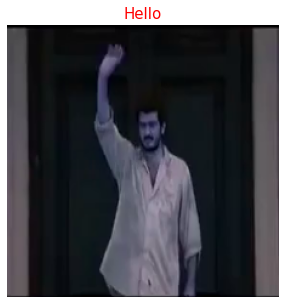

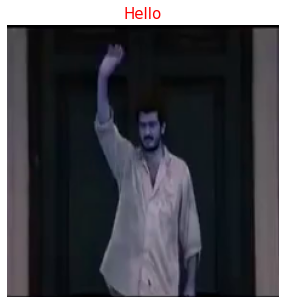

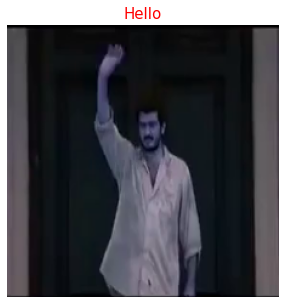

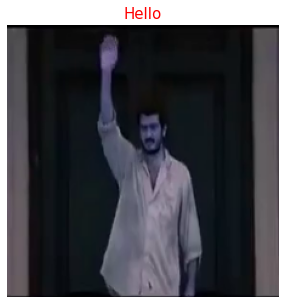

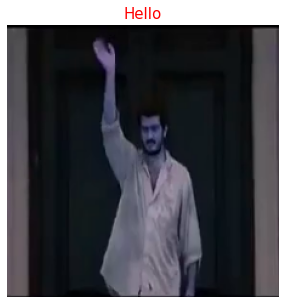

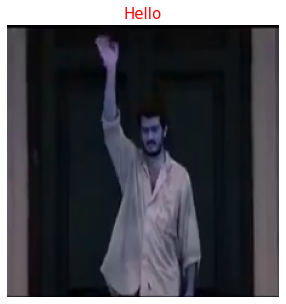

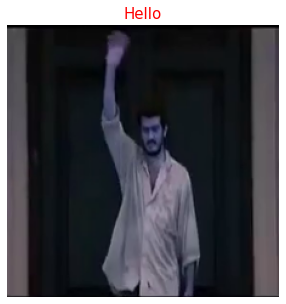

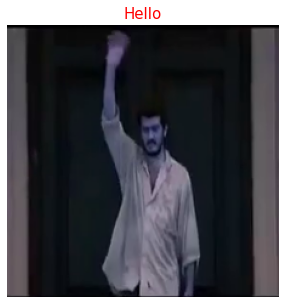

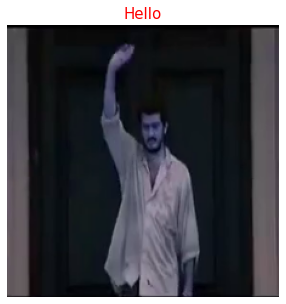

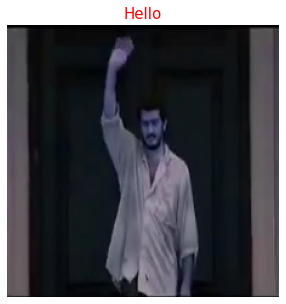

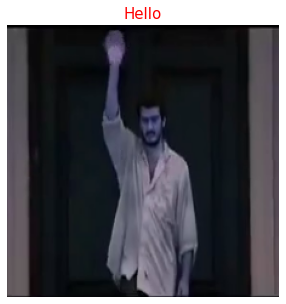

In [197]:
import cv2

#Capturing from Video File
cap = cv2.VideoCapture(path + '/Waving.mp4')

# Get the frames per second
fps = cap.get(cv2.CAP_PROP_FPS) 

# Get the total numer of frames to be counted in the video.
frame_number = 0
frame_count = fps*10  #I am taking first 11 frames i.e for 0 to fps*10 with intervals of  fps

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # optional
#Setting the Target Size of frame that is to be captured
size = (224,224)
# Check if camera/VideoFile opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

# Read until video is completed
while cap.isOpened() and (frame_number <= frame_count):
    
    frame_number += fps
    ret, frame = cap.read()
    frame = cv2.resize(frame, size)

    if ret == True:
            #Using pose_model to predict joints cordinates
            cords = pose_model.predict(frame.reshape(-1,224,224,3))[0]
        
            #Next to it Using clf_model to predicting labels Namste/Hello
            cords= cords.reshape((-1,14))
            action = clf_model.predict_classes(cords)
            
            if action==0:
                action = 'Hello'
            else:
                action = 'Namaste'     
            
            #using Matplotlib to infer what is the level of model understanding
            plt.figure(figsize= (5,5)) 
            plt.imshow(frame); 
            
            plt.title(action, size= 15, color= 'red')
            plt.grid(False);plt.axis(False)                                    

### **As you Can See that given a Frame my Model has Successfully Recognized the Action i.e 'Hello' Here.**

# **Let's Infer More By Giving an Image to the Model**

[150.3906   172.65686  190.4539   198.65668  161.07158  110.362976
  91.49984   46.19076   52.596054 117.16262   42.289616 207.1278
  97.83914  161.81895 ]


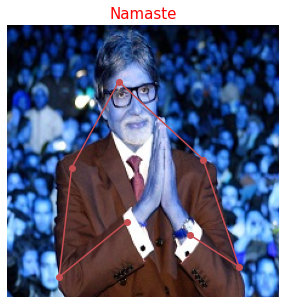

In [232]:
def plot_result(image):
    cords = pose_model.predict(image.reshape(-1,224,224,3))[0]
    print(cords)
    x=[]; y=[]
    for i in range(0,len(cords), 2):
        x.append(cords[i]); y.append(cords[i+1])

    cords= cords.reshape((-1,14))
    action = clf_model.predict_classes(cords)

    if action==0:
        action = 'Hello'
    else:
        action = 'Namaste' 

    plt.figure(figsize= (5,5)) 
    plt.imshow(image);
    plt.plot(x,y,'ro-') 
                
    plt.title(action, size= 15, color= 'red')
    plt.grid(False);plt.axis(False)

image= cv2.imread(path+'/namaste_test.jpg')
plot_result(image)

## **Model has Estimated Pose Fairly Accurate and Exactly Recognized the Action as Greeting Namaste**